In [1]:
import pandas as pd
import collections
import os
import pprint
import seaborn as sns
import json
import pprint
import numpy as np

In [17]:
def get_normalized_throughput(trace):
    currentBitrate = 1000000
    sum_normalized_throughput = 0
    for t in trace:
        currentBitrate = t["currentQuality"]["bitrate"] if t["currentQuality"] else currentBitrate
        currentAverageThroughput = t["currentAverageThroughput"] * 1000
        sum_normalized_throughput += (currentBitrate / currentAverageThroughput)
    return sum_normalized_throughput / len(trace)

In [18]:
def get_jainFairnessIndex(normalized_throughputs):
    numerator = denominator = 0
    for nt in normalized_throughputs:
        numerator += nt
        denominator += (nt**2)
    return (numerator**2) / len(normalized_throughputs) * denominator

In [30]:
def compute_fairness(abrAlgorithm):
    if abrAlgorithm == 'BOLA':
        abrAlgorithm_fairness_dir = './trace/Bola_fairness/two_players'
    elif abrAlgorithm == 'Throughput':
        abrAlgorithm_fairness_dir = './trace/Throughput_fairness/two_players'
    elif abrAlgorithm == 'Dynamic':
        abrAlgorithm_fairness_dir = './trace/Dynamic_fairness/two_players'

    normalized_throughputs_allRuns = []
    jain_fairness_allRuns = []
    for run_folder in os.listdir(abrAlgorithm_fairness_dir):
        if not run_folder.startswith('.'):
            normalized_throughputs = []
            run_folder_path = abrAlgorithm_fairness_dir + '/' + run_folder
            for filename in os.listdir(run_folder_path):
                if not filename.startswith('.'):
                    filepath = run_folder_path + '/' + filename
                    with open(filepath) as f:
                        trace = json.load(f)
                    normalized_throughputs.append(get_normalized_throughput(trace))
            normalized_throughputs_allRuns.append(normalized_throughputs)
    for normalized_throughputs in normalized_throughputs_allRuns:
        jain_fairness_allRuns.append(get_jainFairnessIndex(normalized_throughputs))
    return jain_fairness_allRuns

In [32]:
bola_fairness = compute_fairness('BOLA')

In [33]:
dynamic_fairness = compute_fairness('Dynamic')

In [34]:
throughput_fairness = compute_fairness('Throughput')

In [35]:
abrAlgorithm = ['BOLA'] * 5
abrAlgorithm.extend(['Dynamic'] * 5)
abrAlgorithm.extend(['Throughput'] * 5)
abrAlgorithm

['BOLA',
 'BOLA',
 'BOLA',
 'BOLA',
 'BOLA',
 'Dynamic',
 'Dynamic',
 'Dynamic',
 'Dynamic',
 'Dynamic',
 'Throughput',
 'Throughput',
 'Throughput',
 'Throughput',
 'Throughput']

In [38]:
df = pd.DataFrame(list(zip(bola_fairness, dynamic_fairness, throughput_fairness)), columns=['BOLA', 'Dynamic', 'Throughput'])
df

,BOLA,Dynamic,Throughput
0,0.088258,0.082999,0.063412
1,0.026085,0.024993,0.054117
2,0.058410,0.042296,0.089625
3,0.084991,0.063151,0.025359
4,0.070298,0.060330,0.018624


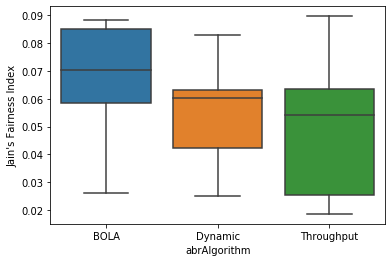

In [43]:
sns.boxplot(x="abrAlgorithm", y="Jain's Fairness Index", data=pd.melt(df, var_name="abrAlgorithm", value_name="Jain's Fairness Index"))